---
# <div align="center"><font color='green'>  </font></div>
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> **Example: Week09 Lecture QandA**</font></div>
---

# Introduction

In this demo we will use MLP to predict the orientation of a face in a 32 by 32 pixel image. The data set used is from: [Chaper 4 of Machine Learning book by Tom Mitchell](http://www.cs.cmu.edu/~tom/faces.html)

The faces of 20 different people are captured at 4 orientations: Left, Right, Up, Straight. Images from each individual is in a separate folder and the label (orientation) for a specific image is given by the image name.  `glickman_up_neutral_sunglasses.pgm -> up`

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__


'2.4.1'

## Loading and setting up dataset

Load the Face dataset. The dataset can be downloaded from canvas (or bitbucket). You can upload it to the notebook work environment and unzip using the following code. 

In [2]:
import zipfile
with zipfile.ZipFile('./faces_TM.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Split the validation-training data. A good practice would be to hold out some individuals for validation. This will eliminate possible overlaps between train/val splits. Lets hold out the last 5 individuals for validation. **To make things simple, We will not be using a test split for this example. This is not good practice. Yoiu should setup a tes set in your experients**

In [3]:
val_persons = ['sz24', 'megak', 'night', 'choon', 'kawamura']

Iterate through the sub folders and read all the image names and create a data frame with relevant information that can be used for training and testing the MLP. 

In [4]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./faces_TM/*/*.jpg', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    person = filepath.split("/")[-2]
    label = filename.split("_")[1]
    val_train = person in val_persons
    image_list.append((filepath, label, int(val_train)))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label', 'isVal'])

In [29]:
data

image_path  label  isVal  \
0     ./faces_TM/megak/megak_up_angry_sunglasses_4.jpg     up      1   
1         ./faces_TM/megak/megak_left_happy_open_4.jpg   left      1   
2         ./faces_TM/megak/megak_up_neutral_open_4.jpg     up      1   
3    ./faces_TM/megak/megak_left_neutral_sunglasses...   left      1   
4    ./faces_TM/megak/megak_left_happy_sunglasses_4...   left      1   
..                                                 ...    ...    ...   
619     ./faces_TM/danieln/danieln_left_sad_open_4.jpg   left      0   
620  ./faces_TM/danieln/danieln_right_happy_open_4.jpg  right      0   
621  ./faces_TM/danieln/danieln_left_sad_sunglasses...   left      0   
622  ./faces_TM/danieln/danieln_left_angry_sunglass...   left      0   
623     ./faces_TM/danieln/danieln_up_angry_open_4.jpg     up      0   

     labels_num  
0             3  
1             0  
2             3  
3             0  
4             0  
..          ...  
619           0  
620           1  
621           0  
622           0  
623           3  

[624 rows x 4 columns]

Lets look at the lable distribution

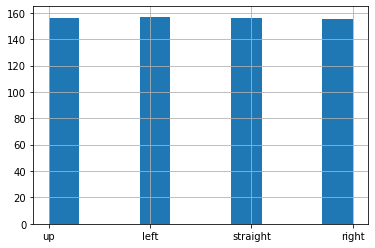

In [5]:
data.label.hist()
plt.show()

**What is your observation?**

Lets plot some random images and observe

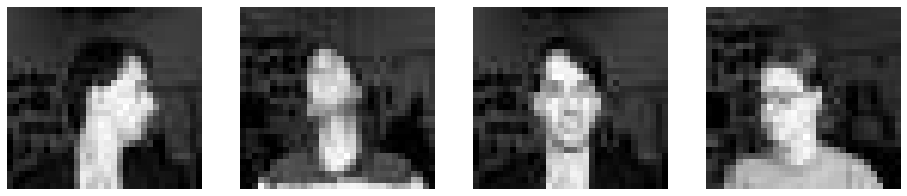

In [6]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

Convert string labels to numeric

In [7]:
d = {'left':0, 'right':1, 'straight':2, 'up':3}
data['labels_num'] = data['label'].map(d, na_action='ignore')

Generate two data frames for training and validation

In [8]:
train_df = data[data['isVal']==0].reset_index()
validation_df = data[data['isVal']==1].reset_index()
print('Train size: {}, Val size: {}'.format(train_df.shape[0], validation_df.shape[0] ) )
N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]

train_df.to_csv('TrainData.csv')
validation_df.to_csv('ValData.csv')

Train size: 469, Val size: 155


We will now design and train an extremely simple neural network (MLP) with one hidden layer.
Two of the choices are made for us by the data.
We have 28x28x3 features and four classes, so the input layer must have 2352 units, and the output layer must have 4 units.
We only have to define the hidden layers.
We're only going to have one hidden layer for this project, and we'll give it 256 nodes/neurons/units.

## Build the model - Base model

We will use tensorflow to build our neural network and train. To be precise, we will be using Keras which is a high level API which is part of tensorflow.
Building the neural network requires configuring the layers of the model, then compiling the model and finally training the model.

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most neural networks consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

A layer in the MLP is represented by `tf.keras.layers.Dense`. First lets define the dimetions of our neural network.


In [9]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

There are three ways to build a model in tensorflow: 
 - Functional API
 - Sub-classing
 - Sequential API

We will use the `Sequential` API to build models as it is the simplest.

In [10]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

2022-05-17 22:36:19.370027: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-17 22:36:19.382643: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 22:36:19.386907: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 * 3 = 2352 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected (MLP), neural layers. The first Dense layer has 256 nodes (or neurons). The second (and last) layer returns a logits array with length of 4. Each node contains a score that indicates the current image belongs to one of the 4 classes.

We can use `model.summary()` to print the model that was created.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               602368    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 603,396
Trainable params: 603,396
Non-trainable params: 0
_________________________________________________________________


The `tf.keras.utils.plot_model` shows the model as a figure

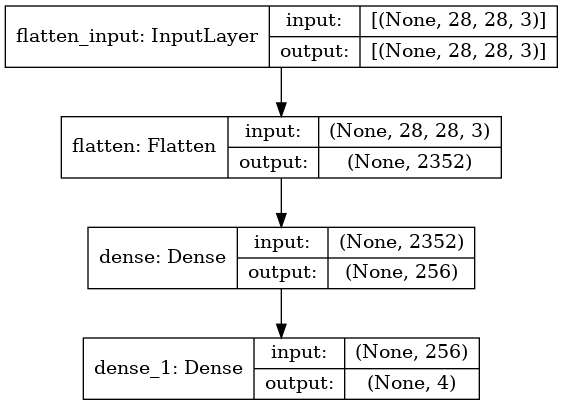

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.



In [13]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

There are many optimizers that are available but for now, we will use SGD.
Here, we have used categorical_crossentropy because there are more than two categories in the output variable.


### Data loader
As are going to work with much larger and more complicated data set, that neural network are more suited towards, we need to write efficient code to load the data in batches to memory. This is done in keras using Image data generators. 

To help we will define a loading function that takes the data frames we defined earlier:

*It seems that dataloader does not like to read one channel images. It automatically converts them to 3-channel images. Lets ignore this for now.* 

We can use the `flow_from_dataframe` function in the keras data loader to load a set of images directly from a pandas data frame (the data frame should contain the image names (path) and the labels)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 469 validated image filenames belonging to 4 classes.
Found 155 validated image filenames belonging to 4 classes.


With this, the training the validation data can be loaded.
You will need to supply the appropriate directory. Usually each pixels varies from 0-255, but it's highly recommended to normalize them in range of 0-1 to speed up the training process.
The dataloader also do a simple normalisation on the pixel values directly.

Now we can use a simple model.fit\_generator() in Keras to train the model. 

### Model training
Next we can train the model. The training is done in the fit function. Since we have already setup a data generator, we can use the fit_generator to do the training. 

In [15]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

/home/ubuntu/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-17 22:36:20.647307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-17 22:36:20.655342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494130000 Hz


The `history` variable will now hold the information to plot the training curves. Lets plot the infomrmation. 

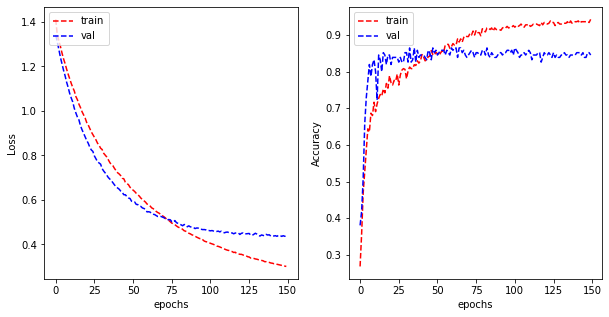

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

**What do you think of the base model?**


## Do some regularization
It seems like the base model is over fitting. Lets now do some incremental updates based on our observations to improve the model. We discussed several techniques to use when a model is overfitting. 

first, Lets add some ridge penalty. This requires us to create a new model.

In [17]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [18]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Train the regularized model

In [19]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

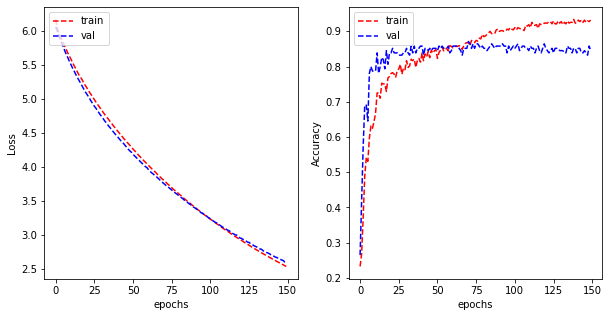

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

Is the model still overfitting? **How can you tune this parameter to balance overfitting/underfitting**

## Try some dropout

Another technique to reduce over-fitting in neural networks is Dropout. 
Lets create a model with dropout and see if that can also help with overfitting (no regularization)

In [21]:
reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [22]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [23]:
history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

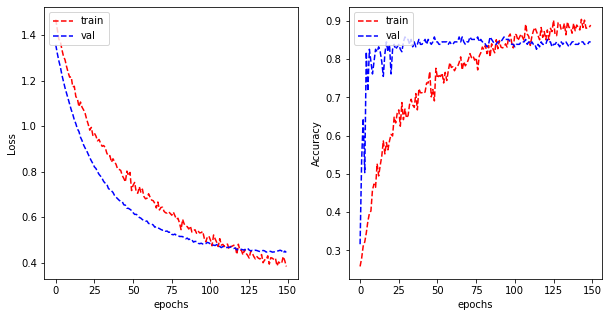

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_drop.history['loss'], 'r--')
plt.plot(history_drop.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_drop.history['categorical_accuracy'], 'r--')
plt.plot(history_drop.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

### Saving the trained model

We can also save the trained model (weights) to be used later for inference.

In [25]:
model.save("base_model")

2022-05-17 22:38:51.899449: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: base_model/assets


Later we can load the model using:

In [26]:
base_model = tf.keras.models.load_model('base_model')

**Try changing the dropout and check if you can reduce overfitting.**

## Predict on random images from test set

Since we dont have an independet test set for this data, we will test on the validation set. **This is clearly not a good stratergy.**

First we will create a data generator to get the test data

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')


Found 155 validated image filenames belonging to 4 classes.


Now lets plot for test data

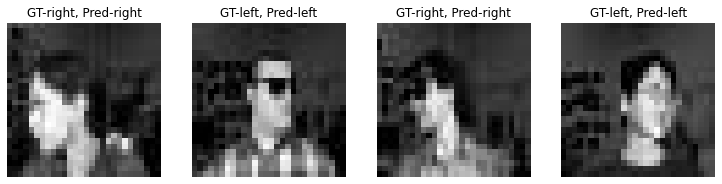

In [28]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')